<a href="https://colab.research.google.com/github/Sukrut11/Audio-Filter/blob/main/Noise_Suppression_of_Audio_Signals_using_FFT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install pysoundfile
#!pip install bitstring

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import IPython
import wave
import struct
import threading
import librosa
import matplotlib.pyplot as plt

Mounted at /content/drive


In [ ]:
!ls "/content/drive/MyDrive"

 Classroom
'Colab Notebooks'
 content
 Cracking-the-Coding-Interview-6th-Edition-189-Programming-Questions-and-Solutions.pdf
 DBMS.gslides
'Document 1 from Sukrut Mayekar.pdf'
'Document from Sukrut Mayekar.pdf'
'Electric Field Intensity due to charge distribution.gdoc'
'ESSENTIAL MATH FOR DATA SCIENCE take control of your data with fundamental calculus, linear... algebra, probability, and statistics by Jean, Hadrien.zip'
 fft.mp4
 noisyflute.m4a
 noisyflute.wav
 PVG_Computational_Statistics
'radha krishna.jpg'
'Untitled presentation.gslides'
 whistle_filtered.wav


In [ ]:
audiofile =  '/content/drive/MyDrive/noisyflute.m4a'

In [ ]:
IPython.display.Audio(audiofile)

Converting m4a file to wav format
Since the original file is m4a format, we need to convert it in wav format for performing any operations

In [ ]:
!pip install pydub
from pydub import AudioSegment

In [ ]:
file_extension = 'm4a'
track = AudioSegment.from_file(audiofile, file_extension)
audiofile_wave = audiofile.replace(file_extension, 'wav')
file_handle = track.export(audiofile_wave, format='wav')
print(audiofile_wave)

/content/drive/MyDrive/noisyflute.wav


In [ ]:
IPython.display.Audio(audiofile_wave)

##Reading wav file

Channels: A standard wave file consist of 2 channels,

    wav_file.setnchannels(1) ensures that this is a mono-sound. For stereo use: wav_file.setnchannels(2)

Each Channel sample is stored as a 16bit Signed number Hence can have range (**-32768** : **+32767** )

**Sample rate**: Audio signals are analog, but we want to represent them digitally. Meaning we want to discretize them in value and in time. The sample rate gives how many times per second we get a value. The unit is Hz.

The sample rate needs to be at least double of the highest frequency in the original sound [Based on Nyquist theorm which states that to retain freq f we should sample at rate 2f] otherwise you get aliasing.

Human hearing range goes from ~20Hz to ~20kHz, so you can cut off anything above 20kHZ. Meaning a sample rate of more than 40kHz does not make much sense

**Bit-depth**: The higher the bit-depth, the more dynamic range can be captured. Dynamic range is the difference between the quietest and loudest volume of an instrument, part or piece of music. A typical value seems to be 16 bit or 24 bit. A bit-depth of 16 bit has a theoretical dynamic range of 96 dB, whereas 24 bit has a dynamic range of 144 dB (source).

**Subtype**: PCM_16 means 16 bit depth, where PCM stands for Pulse-Code Modulation.

In [ ]:
# from scipy.io import wavfile
# fs, data = wavfile.read(audiofile_wave)
# print(fs, len(data))
from scipy import fftpack

wav_file = wave.open(audiofile_wave, 'r')
nchannels, sampwidth, framerate, nframes, comptype, compname = wav_file.getparams()
print("Params:", "\n\tChannel:", nchannels, "\n\tSample Width:", sampwidth, "\n\tFramerate:", framerate, "\n\tNumber of Frames:", nframes, "\n\tcomptype:", comptype, "\n\tCompname:", compname)

# Reading wave format data from wav file.
frames_wave = wav_file.readframes(nframes)
wav_file.close()

print("Length:", nframes)

# Deserializing
frames_wave = struct.unpack('{n}h'.format(n=nframes), frames_wave)
frames_wave = np.array(frames_wave)
print("Min value:", np.min(frames_wave), "Max value:", np.max(frames_wave))

Params: 
	Channel: 1 
	Sample Width: 2 
	Framerate: 44100 
	Number of Frames: 444416 
	comptype: NONE 
	Compname: not compressed
Length: 444416
Min value: -16824 Max value: 21114


Above since the `Min value`: **-32426** `Max value`: **32767** theirfore its a 16bit file.

In [ ]:
# Fast Fourier Transform
# frames_freq_domian = np.fft.fft(frames_wave)
frames_freq_domian = fftpack.fft(frames_wave)

# Above value is in complex number but we want absolute number
# This will give us the frequency we want
magnitude = np.abs(frames_freq_domian)  # Or ampliude ?
phase = np.angle(frames_freq_domian) # Normally we are not interested in phase information, its only used in reconstruction.

print(magnitude.shape, phase.shape)
print("The max frequency (highest magnitude) is {} Hz".format(np.where(magnitude == np.max(magnitude))[0][0]))

(444416,) (444416,)
The max frequency (highest magnitude) is 3476 Hz


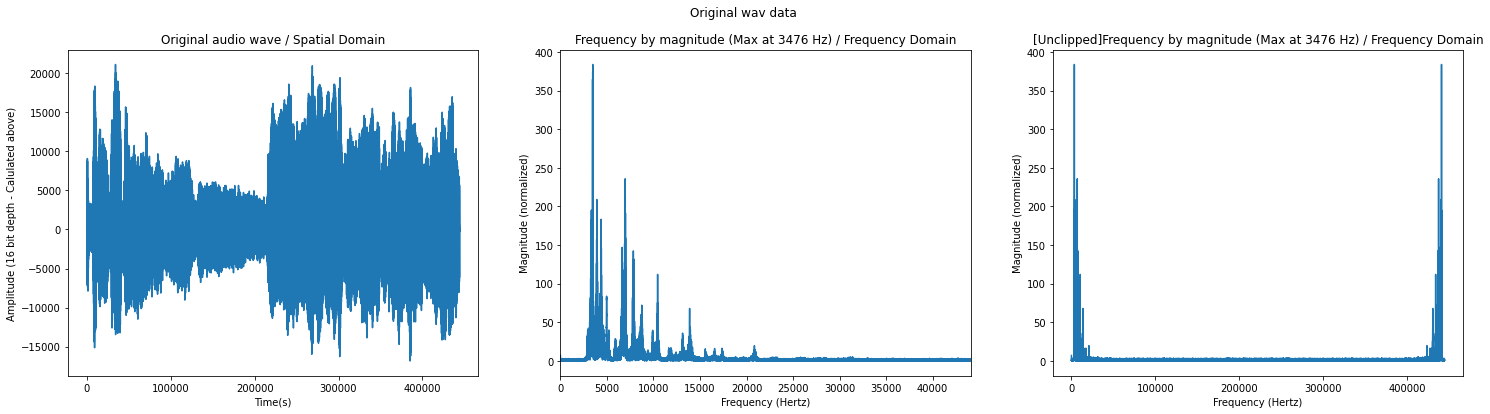

In [ ]:
fig = plt.figure(figsize = (25, 6))
fig.suptitle('Original wav data')

ax1 = fig.add_subplot(1,3,1)
ax1.set_title("Original audio wave / Spatial Domain")
ax1.set_xlabel("Time(s)")
ax1.set_ylabel("Amplitude (16 bit depth - Calulated above)")

ax1.plot(frames_wave)

ax2 = fig.add_subplot(1,3,2)
ax2.set_title("Frequency by magnitude (Max at {} Hz) / Frequency Domain".format(np.where(magnitude == np.max(magnitude))[0][0]))
ax2.set_xlabel("Frequency (Hertz)")
ax2.set_ylabel("Magnitude (normalized)")
ax2.set_xlim(0, 44100)  # we are not interested in rest
ax2.plot(magnitude / nframes)  # Normalizing magnitude

ax3 = fig.add_subplot(1,3,3)
ax3.set_title("[Unclipped]Frequency by magnitude (Max at {} Hz) / Frequency Domain".format(np.where(magnitude == np.max(magnitude))[0][0]))
ax3.set_xlabel("Frequency (Hertz)")
ax3.set_ylabel("Magnitude (normalized)")
ax3.plot(magnitude / nframes)  # Normalizing magnitude

plt.show()

If we havenot limited the output to 44100 Hz in Frequency domain plot, you would have notice that first half and second half are almost same, complex conjugate (due to above and below sinwaves).

Since human being can only hear upto 44100Hz Frequency we are not interested in above ranges.
Sound can be expressed in terms of waves, which in turn have frequency components. If we mask some frequency, we can remove noise. Which frequency to mask is the matter of trial and error. Since we dont have past data to train on it cannot be a ML based task.

In simplicity we want to allow a certain range of freuency and mask other, like appying a rectangular window over the whole signal. Now sinc func representation in frequency domain is a rectange, we can use it as an ideal filter. We just need to place this over our signal in freq domain and multiply (Amplitude modulation), then take a IFFT and get filtered singal back.

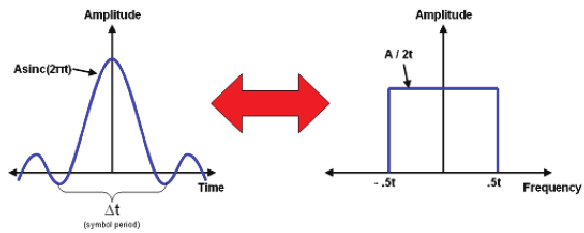

But based on nature of sinc it is not possible since it never reaches zero and if we have to use this we need to calculate value till infinity. So we can take a approximation here and settle with something in between.

Now above is just a explanation and their are many filters and their types. scipy comes with lots of them already built in and their is no need to dive in the maths, we just need to use the functions exposed.

Filters never add any new frequency components to the sound. They can only scale the amplitudes of already existing frequencies.

normal_cutoff: 0.06802721088435375 15116.190476190477


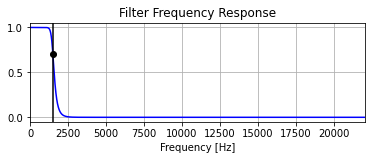

(444416,) (444416,) False


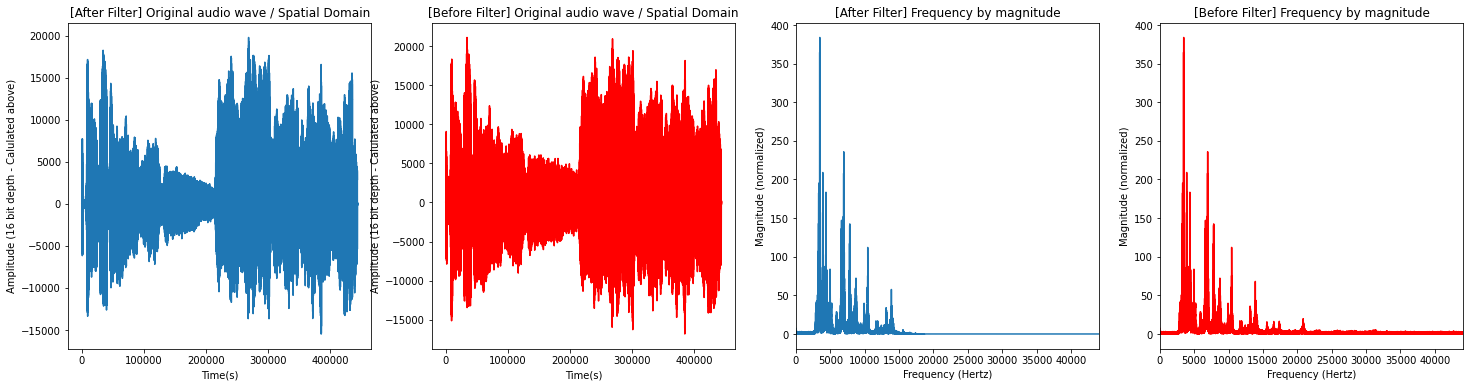

In [ ]:
from scipy import signal
from matplotlib import pyplot as plt

def butter_pass_filter(data, cutoff, fs, order=5):
    nyq = 0.5 * fs # Nyquist frequency
    normal_cutoff = cutoff / nyq  # A fraction b/w 0 and 1 of sampling rate
    print("normal_cutoff:", normal_cutoff, (data.shape[0] / 2) * normal_cutoff) # Tricky ? 
    b, a = signal.butter(order, normal_cutoff, btype='low', analog=False)
    y = signal.filtfilt(b, a, data)

    def _plot_graph():
      # Get the filter coefficients so we can check its frequency response.
      # Plot the frequency response.
      w, h = signal.freqz(b, a, worN=8000)
      plt.subplot(2, 1, 1)
      plt.plot(0.5 *fs*w/np.pi, np.abs(h), 'b')
      plt.plot(cutoff, 0.5 * np.sqrt(2), 'ko')
      plt.axvline(cutoff, color='k')
      plt.xlim(0, 0.5*fs)
      plt.title("Filter Frequency Response")
      plt.xlabel('Frequency [Hz]')
      plt.grid()
      plt.show()
    _plot_graph()
    return y

# Filter requirements.
order = 10
fs = framerate #* 6.28  # sample rate, Hz
cutoff =  1500 #* 6.28      # desired cutoff frequency of the filter, Hz

# Get the filter coefficients so we can check its frequency response.
y = butter_pass_filter(frames_wave, cutoff, fs, order)

print(frames_wave.shape, y.shape, np.array_equal(frames_wave, y))
fig = plt.figure(figsize = (25, 6))
# fig.suptitle('Horizontally stacked subplots')

ax1 = fig.add_subplot(1,4,1)
ax1.set_title("[After Filter] Original audio wave / Spatial Domain")
ax1.set_xlabel("Time(s)")
ax1.set_ylabel("Amplitude (16 bit depth - Calulated above)")
ax1.plot(y)

ax2 = fig.add_subplot(1,4,2)
ax2.set_title("[Before Filter] Original audio wave / Spatial Domain")
ax2.set_xlabel("Time(s)")
ax2.set_ylabel("Amplitude (16 bit depth - Calulated above)")
ax2.plot(frames_wave, 'r')


m = np.abs(fftpack.fft(y))
ax3 = fig.add_subplot(1,4,3)
ax3.set_title("[After Filter] Frequency by magnitude")
ax3.set_xlabel("Frequency (Hertz)")
ax3.set_ylabel("Magnitude (normalized)")
ax3.set_xlim(0, 44100)  # we are not interested in rest
ax3.plot(np.abs(fftpack.fft(y)) / nframes)
# ax2.plot(range(0, 676864), m, 'g-', label='dataa')


ax4 = fig.add_subplot(1,4,4)
ax4.set_title("[Before Filter] Frequency by magnitude")
ax4.set_xlabel("Frequency (Hertz)")
ax4.set_ylabel("Magnitude (normalized)")
ax4.set_xlim(0, 44100)  # we are not interested in rest
# ax2.plot(magnitude * 2 / (16 * len(magnitude)))
ax4.plot(magnitude / nframes, 'r')

plt.show()
IPython.display.Audio(data=y, rate=44100)

##Writing Filtered signal back to file

In [ ]:
amplitude = 1
filtered_file = "/content/drive/MyDrive/whistle_filtered.wav"
wav_file=wave.open(filtered_file, 'w')
# The tuple should be (nchannels, sampwidth, framerate, nframes, comptype, compname)
wav_file.setparams((nchannels, sampwidth, framerate, nframes, "NONE", "not compressed"))
#Struct is a Python library that takes our data and packs it as binary data. The h in the code means 16 bit number.
for s in y:
  wav_file.writeframes(struct.pack('h', int(s*amplitude)))
wav_file.close()
IPython.display.Audio("/content/drive/MyDrive/whistle_filtered.wav")